<h1 align="center">MSIN0114: Business Analytics Consulting Project</h1>
<h2 align="center">S2R Analytics, pt. 3</h2>

# Table of Contents

* [Part 5](#part5): Regression
    * [5.0](#5_0): Data splitting
    * [5.1](#5_1): Models
    * [5.2](#5_2): Models comparison
<br />
<br />
* [Part 6](#part6): Classification
    * [6.0](#6_0): Data splitting
    * [6.1](#6_1): Models
    * [6.2](#6_2): Models comparison
<br />
<br />
* [Part 7](#part7): Fine-tuning
* [Part 8](#part8): Ensemble learning
* [Part 9](#part9): Evaluation of the final model
* [Part 10](#part10): Pipeline creation

## Notebook Setup

In [45]:
#Essentials
import pandas as pd
from pandas import Series, DataFrame
from pandas.api.types import CategoricalDtype
pd.options.display.max_columns = None
import sqlite3
import pyodbc
import numpy as np; np.random.seed(1)

#Image creation and display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.ticker import FuncFormatter

#Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 

from sklearn.decomposition import PCA

#Metrics of accuracy
from numpy import mean
from numpy import std
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Fine-tuning and enseble learning
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

#Other
import itertools as it
import io
import os
os.sys.path
import sys
import glob
import concurrent.futures
from __future__ import print_function
import binascii
import struct
from PIL import Image
import scipy
import scipy.misc
import scipy.cluster
import datetime, time
import functools, operator
from datetime import datetime
from numpy.random import seed
from numpy.random import randn
from numpy import percentile

In [46]:
df = pd.read_csv('csv-files/preprocessed_data.csv')

If two features are collinear it means that they should have a Pearson correlation coefficient far away from 0, and much closer to 1 or -1.

In [21]:
#URL: https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-pandas-columns-in-python
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

calculate_vif_(df)

dropping 'Director_ID' at index: 14
dropping 'Avg_Rec' at index: 21
dropping 'Manager_ID' at index: 10
dropping 'Delivered_on_Time' at index: 18
dropping 'Office' at index: 1
dropping 'Avg_Profit' at index: 18
dropping 'Rec_Class' at index: 18
dropping 'Director_Team' at index: 12
dropping 'Total_Num_Stages' at index: 4
dropping 'Director_Empl_Months' at index: 12
dropping 'Profit_Class' at index: 15
Remaining variables:
Index(['Country', 'Sector', 'Project_Size_Sort_Order',
       'Project_Duration_Weeks', 'Is_Multi_Discipline_Project',
       'Is_First_Client_Project', 'Default_Rate_Group',
       'Perc_of_Stages_with_Fixed_Fee', 'Manager_Team', 'Manager_Is_Recent',
       'Manager_Empl_Months', 'Director_Is_Recent', 'Perc_of_Subcontractors',
       'Is_Front_Loaded', 'Total_Data_Issues'],
      dtype='object')


,Country,Sector,Project_Size_Sort_Order,Project_Duration_Weeks,Is_Multi_Discipline_Project,Is_First_Client_Project,Default_Rate_Group,Perc_of_Stages_with_Fixed_Fee,Manager_Team,Manager_Is_Recent,Manager_Empl_Months,Director_Is_Recent,Perc_of_Subcontractors,Is_Front_Loaded,Total_Data_Issues
0,0,6,4.0,4.0,0,1,1,0.80,7,0,125.0,0,0.0,1,2.0
1,0,0,1.0,238.0,0,1,1,0.00,4,0,317.0,0,0.0,0,2.0
2,0,0,1.0,0.0,0,1,1,0.00,4,0,317.0,0,0.0,0,0.0
3,0,1,3.0,121.0,0,1,1,0.25,4,0,317.0,0,0.0,0,1.0
4,0,0,7.0,2.0,0,1,1,0.00,4,0,419.0,0,0.0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9626,0,9,3.0,18.0,0,0,0,1.00,5,0,176.0,0,0.0,0,1.0
9627,0,0,1.0,1.0,0,0,0,0.67,15,0,11.0,0,0.0,0,1.0
9628,0,0,1.0,1.0,0,0,0,0.50,16,0,28.0,1,0.0,0,1.0
9629,0,3,1.0,3.0,0,0,0,1.00,9,0,168.0,0,0.0,0,0.0


## Part 5: <a class="anchor" id="part5"></a> Regression

### 5.0 <a class="anchor" id="5_0"></a> Data splitting

In [22]:
# Choose dependent variables
Y = df[['Avg_Rec']]

# Drop the dependent variables from the feature data set
X = df[['Country', 'Sector', 'Project_Size_Sort_Order',
       'Project_Duration_Weeks', 'Is_Multi_Discipline_Project',
       'Is_First_Client_Project', 'Default_Rate_Group',
       'Perc_of_Stages_with_Fixed_Fee', 'Manager_Team', 'Manager_Is_Recent',
       'Manager_Empl_Months', 'Director_Is_Recent', 'Perc_of_Subcontractors',
       'Is_Front_Loaded', 'Total_Data_Issues']]

# Scale the explanatory variables
X1 = pd.DataFrame(preprocessing.normalize(X))
X1.columns = X.columns
X = X1

# Split data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1)

print(f'No. of training data: {X_train.shape[0]}')
print(f'No. of training targets: {Y_train.shape[0]}')
print(f'No. of testing data: {X_test.shape[0]}')
print(f'No. of testing targets: {Y_test.shape[0]}')

No. of training data: 7704
No. of training targets: 7704
No. of testing data: 1927
No. of testing targets: 1927


### 5.1 <a class="anchor" id="5_1"></a> Models

#### 5.1.1 <a class="anchor" id="5_1_1"></a> Linear regression

In [23]:
lr = LinearRegression()
lr.fit(X_train, Y_train.values.ravel())

# Train data set
y_pred_train_lr = lr.predict(X_train)
lr_mse_train = mean_squared_error(Y_train, y_pred_train_lr)
lr_rmse_train = np.sqrt(lr_mse_train)
lr_r2_train = metrics.r2_score(Y_train, y_pred_train_lr)
print('Linear Regression R2 on train set: ', round(lr_r2_train, 2))

# Test data set
y_pred_test_lr = lr.predict(X_test)
lr_mse_test = mean_squared_error(Y_test, y_pred_test_lr)
lr_rmse_test = np.sqrt(lr_mse_test)
lr_r2_test = metrics.r2_score(Y_test, y_pred_test_lr)
print('Linear Regression R2 on test set: ', round(lr_r2_test, 2))

Linear Regression R2 on train set:  0.05
Linear Regression R2 on test set:  0.04


#### 5.1.2 <a class="anchor" id="5_1_2"></a> Lasso regression

In [24]:
lasso = Lasso(random_state = 1)
lasso.fit(X_train, Y_train.values.ravel())

# Train data set
y_pred_train_lasso = lasso.predict(X_train)
lasso_mse_train = mean_squared_error(Y_train, y_pred_train_lasso)
lasso_rmse_train = np.sqrt(lasso_mse_train)
lasso_R2_train = metrics.r2_score(Y_train, y_pred_train_lasso)
print('Lasso Regression R2 on train set: ', round(lasso_R2_train, 2))

# Test data set
y_pred_test_lasso = lasso.predict(X_test)
lasso_mse_test = mean_squared_error(Y_test, y_pred_test_lasso)
lasso_rmse_test = np.sqrt(lasso_mse_test)
lasso_R2_test = metrics.r2_score(Y_test, y_pred_test_lasso)
print('Lasso Regression R2 on test set: ', round(lasso_R2_test, 2))

Lasso Regression R2 on train set:  0.0
Lasso Regression R2 on test set:  -0.0


#### 5.1.3 <a class="anchor" id="5_1_3"></a> Decision tree regressor

In [25]:
dtr = DecisionTreeRegressor(random_state = 1)
dtr.fit(X_train, Y_train.values.ravel())

# Train data set
y_pred_train_dtr = dtr.predict(X_train)
dtr_mse_train = mean_squared_error(Y_train, y_pred_train_dtr)
dtr_rmse_train = np.sqrt(dtr_mse_train)
dtr_r2_train = metrics.r2_score(Y_train, y_pred_train_dtr)
print('Decision Tree R2 on train set: ', round(dtr_r2_train, 2))

# Test data set
y_pred_test_dtr = dtr.predict(X_test)
dtr_mse_test = mean_squared_error(Y_test, y_pred_test_dtr)
dtr_rmse_test = np.sqrt(dtr_mse_test)
dtr_r2_test = metrics.r2_score(Y_test, y_pred_test_dtr)
print('Decision Tree R2 on test set: ', round(dtr_r2_test, 2))

Decision Tree R2 on train set:  0.98
Decision Tree R2 on test set:  -0.52


#### 5.1.4 <a class="anchor" id="5_1_4"></a> Random forest regressor

In [26]:
rfr = RandomForestRegressor(random_state = 1)
rfr.fit(X_train, Y_train.values.ravel())

# Train data set
y_pred_train_rfr = rfr.predict(X_train)
rfr_mse_train = mean_squared_error(Y_train, y_pred_train_rfr)
rfr_rmse_train = np.sqrt(rfr_mse_train)
rfr_R2_train = metrics.r2_score(Y_train, y_pred_train_rfr)
print('Random Forest R2 on train set: ', round(rfr_R2_train, 2))

# Test data set
y_pred_test_rfr = rfr.predict(X_test)
rfr_mse_test = mean_squared_error(Y_test, y_pred_test_rfr)
rfr_rmse_test = np.sqrt(rfr_mse_test)
rfr_R2_test = metrics.r2_score(Y_test, y_pred_test_rfr)
print('Random Forest R2 on test set: ', round(rfr_R2_test, 2))

Random Forest R2 on train set:  0.87
Random Forest R2 on test set:  0.23


c:\Users\MarfaPopova\S2R Analytics\Development & Support Team - Power BI for Synergy - Advanced Analytics\DataFlowExtract\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


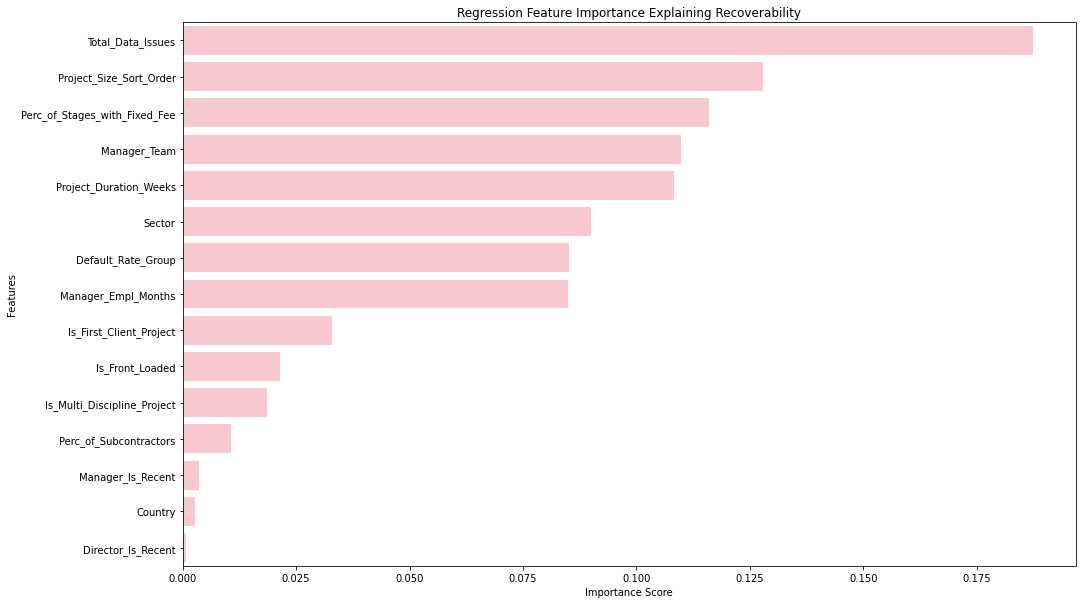

In [27]:
# Create a new DataFrame for feature importance
rfr.feature_names = X.columns
final_feature_importance = pd.DataFrame({'Feature': rfr.feature_names,'Importance':rfr.feature_importances_})
final_feature_importance = final_feature_importance.sort_values(by = ['Importance'], ascending = False)

# Plotting the feature importance graph
fig, ax = plt.subplots(figsize = (16,10))
sns.barplot(final_feature_importance['Importance'], final_feature_importance['Feature'], color = 'pink')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.xticks(rotation = 'horizontal')
plt.title('Regression Feature Importance Explaining Recoverability')
plt.savefig('figures/rec/Regression Feature Importance.png')

#### 5.1.5 <a class="anchor" id="5_1_5"></a> XGBoost regressor

In [28]:
xgbr = XGBRegressor(random_state = 1)
xgbr.fit(X_train, Y_train.values.ravel())

# Train data set
y_pred_train_xgbr = xgbr.predict(X_train)
xgbr_mse_train = mean_squared_error(Y_train, y_pred_train_xgbr)
xgbr_rmse_train = np.sqrt(xgbr_mse_train)
xgbr_R2_train = metrics.r2_score(Y_train, y_pred_train_xgbr)
print('XGBoost R2 on train set: ', round(xgbr_R2_train, 2))

# Test data set
y_pred_test_xgbr = xgbr.predict(X_test)
xgbr_mse_test = mean_squared_error(Y_test, y_pred_test_xgbr)
xgbr_rmse_test = np.sqrt(xgbr_mse_test)
xgbr_R2_test = metrics.r2_score(Y_test, y_pred_test_xgbr)
print('XGBoost R2 on test set: ', round(xgbr_R2_test, 2))

XGBoost R2 on train set:  0.73
XGBoost R2 on test set:  0.23


### 5.2  <a class="anchor" id="5_2"></a> Models comparison

The highest R2 score is 0.26 by  XGBoost regressor, making regression models very unreliable in this case.

* Conclusion: Regression does not work for this dataset.
* Reason: The results of test dataset are way too diferent from nearly perfect training results, e.g. 0.74 versus 0.26 for XGBoost.
* Cause: The continuous uints of dependent varuable 'Avg_Rec' are very close to wach other, making it difficult for the algorithm to see a pattern between such similar distances between each point. - **NOT TRUE, IT SHOULD WORK**
* Next: Classification should work better.

## Part 6: <a class="anchor" id="part6"></a> Classification

### 6.0 <a class="anchor" id="6_0"></a> Data splitting

In [29]:
# Choose dependent variables
Y = df[['Rec_Class']]

# Drop the dependent variables from the feature data set
X = df[['Country', 'Sector', 'Project_Size_Sort_Order',
       'Project_Duration_Weeks', 'Is_Multi_Discipline_Project',
       'Is_First_Client_Project', 'Default_Rate_Group',
       'Perc_of_Stages_with_Fixed_Fee', 'Manager_Team', 'Manager_Is_Recent',
       'Manager_Empl_Months', 'Director_Is_Recent', 'Perc_of_Subcontractors',
       'Is_Front_Loaded', 'Total_Data_Issues']]

# Split data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1, stratify = Y)

print(f'No. of training data: {X_train.shape[0]}')
print(f'No. of training targets: {Y_train.shape[0]}')
print(f'No. of testing data: {X_test.shape[0]}')
print(f'No. of testing targets: {Y_test.shape[0]}')

No. of training data: 7704
No. of training targets: 7704
No. of testing data: 1927
No. of testing targets: 1927


### 6.1 <a class="anchor" id="6_1"></a> Models

#### 6.1.1  <a class="anchor" id="6_1_1"></a> Logistic Regression

In [59]:
# Create a logistic regression model
log = LogisticRegression(random_state = 1, max_iter = 30000)

# Train the model using train set
log.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
log_y_pred=log.predict(X_test)

# Accuracy measures
print("Accuracy score of LOG: " + str(round(metrics.accuracy_score(Y_test, np.round(log_y_pred)), 3)*100)+"%")
print("Precision score of LOG: " + str(round(metrics.precision_score(Y_test, np.round(log_y_pred), average="weighted", zero_division=0), 3)*100)+"%")
print("Recall score of LOG: " + str(round(metrics.recall_score(Y_test, np.round(log_y_pred), average="weighted", zero_division=0), 3)*100)+"%")
print("F1 of LOG: " + str(round(metrics.f1_score(Y_test, np.round(log_y_pred), average="weighted"), 3)*100)+"%")

Accuracy score of LOG: 57.3%
Precision score of LOG: 55.60000000000001%
Recall score of LOG: 57.3%
F1 of LOG: 56.49999999999999%


#### 6.1.2 <a class="anchor" id="6_1_2"></a> KNeighbors classifier

In [32]:
# Create KNN Classifier model
np.random.seed(1)
knn_3 = KNeighborsClassifier(n_neighbors = 3)

# Train the model using train set
knn_3.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
knn_3_y_pred = knn_3.predict(X_test)

# Accuracy measures
print("Accuracy score of KNN-3: " + str(round(metrics.accuracy_score(Y_test, np.round(knn_3_y_pred)), 3)*100)+"%")
print("Precision score of KNN-3: " + str(round(metrics.precision_score(Y_test, np.round(knn_3_y_pred), average="weighted", zero_division=1), 3)*100)+"%")
print("Recall score of KNN-3 " + str(round(metrics.recall_score(Y_test, np.round(knn_3_y_pred), average="weighted"), 3)*100)+"%")
print("F1 of KNN-3: " + str(round(metrics.f1_score(Y_test, np.round(knn_3_y_pred), average="weighted"), 3)*100)+"%")

Accuracy score of KNN-3: 57.8%
Precision score of KNN-3: 58.099999999999994%
Recall score of KNN-3 57.8%
F1 of KNN-3: 57.9%


In [57]:
np.random.seed(1)
knn_7 = KNeighborsClassifier(n_neighbors=7)
knn_7.fit(X_train, Y_train.values.ravel())
knn_7_y_pred = knn_7.predict(X_test)

print("Accuracy score of KNN-7: " + str(round(metrics.accuracy_score(Y_test, np.round(knn_7_y_pred)), 3)*100)+"%")
print("Precision score of KNN-7: " + str(round(metrics.precision_score(Y_test, np.round(knn_7_y_pred), average="weighted", zero_division=1), 3)*100)+"%")
print("Recall score of KNN-7 " + str(round(metrics.recall_score(Y_test, np.round(knn_7_y_pred), average="weighted"), 3)*100)+"%")
print("F1 of KNN-7: " + str(round(metrics.f1_score(Y_test, np.round(knn_7_y_pred), average="weighted"), 3)*100)+"%")

Accuracy score of KNN-7: 58.4%
Precision score of KNN-7: 56.8%
Recall score of KNN-7 58.4%
F1 of KNN-7: 57.599999999999994%


#### 6.1.3  <a class="anchor" id="6_1_3"></a> Decision tree classifier

In [55]:
# Create Decision Tree Classifier model
dtc = DecisionTreeClassifier(random_state = 1)

# Train the model using train set
dtc = dtc.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
dtc_y_pred = dtc.predict(X_test)

# Accuracy measures
print("Accuracy score of DTC: " + str(round(metrics.accuracy_score(Y_test, np.round(dtc_y_pred)), 3)*100)+"%")
print("Precision score of DTC: " + str(round(metrics.precision_score(Y_test, np.round(dtc_y_pred), average="weighted", zero_division=1), 3)*100)+"%")
print("Recall score of DTC: " + str(round(metrics.recall_score(Y_test, np.round(dtc_y_pred), average="weighted"), 3)*100)+"%")
print("F1 of DTC: " + str(round(metrics.f1_score(Y_test, np.round(dtc_y_pred), average="weighted"), 3)*100)+"%")

Accuracy score of DTC: 61.0%
Precision score of DTC: 61.0%
Recall score of DTC: 61.0%
F1 of DTC: 61.0%


#### 6.1.4  <a class="anchor" id="6_1_4"></a> Random forest classifier

In [53]:
# Create a Gaussian Classifier model
rfc = RandomForestClassifier(random_state = 1)

# Train the model using train set
rfc.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
rfc_y_pred=rfc.predict(X_test)

# Accuracy measures
print("Accuracy score of RFC: " + str(round(metrics.accuracy_score(Y_test, np.round(rfc_y_pred)), 3)*100)+"%")
print("Precision score of RFC: " + str(round(metrics.precision_score(Y_test, np.round(rfc_y_pred), average="weighted", zero_division=1), 3)*100)+"%")
print("Recall score of RFC: " + str(round(metrics.recall_score(Y_test, np.round(rfc_y_pred), average="weighted"), 3)*100)+"%")
print("F1 of RFC: " + str(round(metrics.f1_score(Y_test, np.round(rfc_y_pred), average="weighted"), 3)*100)+"%")

Accuracy score of RFC: 68.7%
Precision score of RFC: 67.60000000000001%
Recall score of RFC: 68.7%
F1 of RFC: 67.80000000000001%


#### 6.1.5  <a class="anchor" id="6_1_5"></a> Gaussian classifier

In [36]:
import xgboost as xgb
print(xgb.__version__)

1.6.1


In [61]:
# Create a XGBoost model
xgbc = XGBClassifier(n_estimators=100, learning_rate=0.05, booster='gbtree', random_state = 1, eval_metric='mlogloss', use_label_encoder=False)

# Train the model using train set
xgbc.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
xgbc_y_pred=xgbc.predict(X_test)

# Accuracy measures
print("Accuracy score of XGBC: " + str(round(metrics.accuracy_score(Y_test, np.round(xgbc_y_pred)), 3)*100)+"%")
print("Precision score of XGBC: " + str(round(metrics.precision_score(Y_test, np.round(xgbc_y_pred), average="weighted", zero_division=1), 3)*100)+"%")
print("Recall score of XGBC: " + str(round(metrics.recall_score(Y_test, np.round(xgbc_y_pred), average="weighted"), 3)*100)+"%")
print("F1 of XGBC: " + str(round(metrics.f1_score(Y_test, np.round(xgbc_y_pred), average="weighted"), 3)*100)+"%")

Accuracy score of XGBC: 70.5%
Precision score of XGBC: 69.5%
Recall score of XGBC: 70.5%
F1 of XGBC: 69.39999999999999%


c:\Users\MarfaPopova\S2R Analytics\Development & Support Team - Power BI for Synergy - Advanced Analytics\DataFlowExtract\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


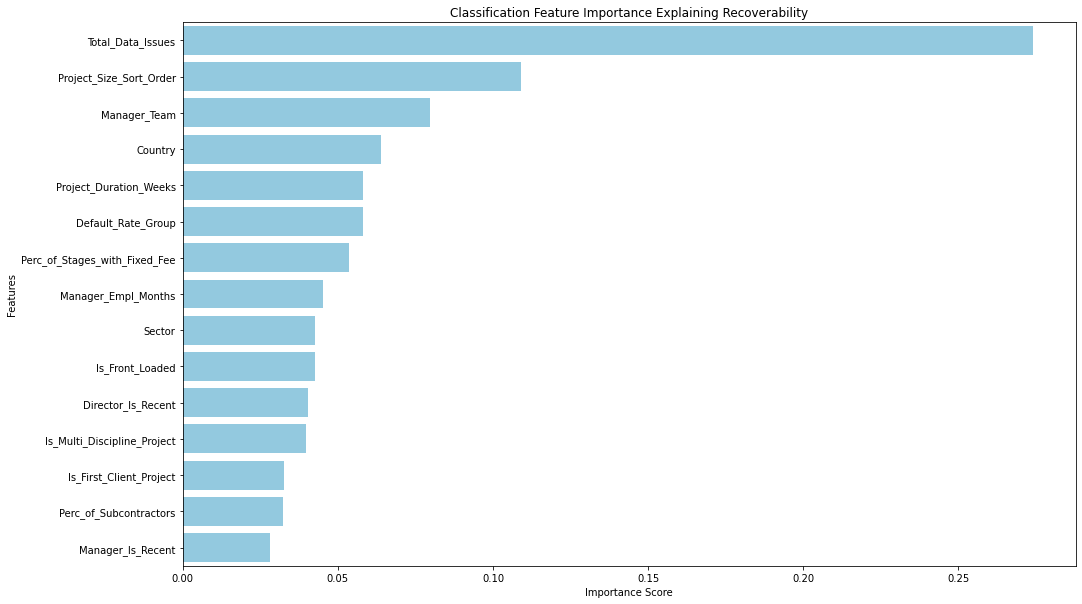

In [62]:
# Create a new DataFrame for feature importance
xgbc.feature_names = X.columns
final_feature_importance = pd.DataFrame({'Feature': xgbc.feature_names,'Importance':xgbc.feature_importances_})
final_feature_importance = final_feature_importance.sort_values(by = ['Importance'], ascending = False)

# Plotting the feature importance graph
fig, ax = plt.subplots(figsize = (16,10))
sns.barplot(final_feature_importance['Importance'], final_feature_importance['Feature'], color = 'skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.xticks(rotation = 'horizontal')
plt.title('Classification Feature Importance Explaining Recoverability')
plt.savefig('figures/rec/Classification Feature Importance.png')

#### 6.1.6  <a class="anchor" id="6_1_6"></a> Naive Bayes

In [50]:
# Create a XGBoost model
gnb = GaussianNB()

# Train the model using train set
gnb.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
gnb_y_pred = gnb.predict(X_test)

# Accuracy measures
print("Accuracy score of GNB: " + str(round(metrics.accuracy_score(Y_test, np.round(gnb_y_pred)), 3)*100)+"%")
print("Precision score of GNB: " + str(round(metrics.precision_score(Y_test, np.round(gnb_y_pred), average="weighted", zero_division=1), 3)*100)+"%")
print("Recall score of GNB: " + str(round(metrics.recall_score(Y_test, np.round(gnb_y_pred), average="weighted"), 3)*100)+"%")
print("F1 of GNB: " + str(round(metrics.f1_score(Y_test, np.round(gnb_y_pred), average="weighted"), 3)*100)+"%")

Accuracy score of GNB: 52.7%
Precision score of GNB: 56.00000000000001%
Recall score of GNB: 52.7%
F1 of GNB: 48.6%


#### 6.1.7  <a class="anchor" id="6_1_7"></a> Linear discriminant analysis

In [40]:
# Create a QDA model
lda = LinearDiscriminantAnalysis(n_components = 2)

# Train the model using train set
lda.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
lda_y_pred = lda.predict(X_test)

# Accuracy measures
print("Accuracy score of LDA: " + str(round(metrics.accuracy_score(Y_test, np.round(lda_y_pred)), 3)*100)+"%")
print("Precision score of LDA: " + str(round(metrics.precision_score(Y_test, np.round(lda_y_pred), average="weighted", zero_division=1), 3)*100)+"%")
print("Recall score of LDA: " + str(round(metrics.recall_score(Y_test, np.round(lda_y_pred), average="weighted"), 3)*100)+"%")
print("F1 of LDA: " + str(round(metrics.f1_score(Y_test, np.round(lda_y_pred), average="weighted"), 3)*100)+"%")

Accuracy score of LDA: 56.599999999999994%
Precision score of LDA: 57.9%
Recall score of LDA: 56.599999999999994%
F1 of LDA: 55.800000000000004%


#### 6.1.8  <a class="anchor" id="6_1_8"></a> Quadratic discriminant analysis

In [48]:
# Create a QDA model
qda = QuadraticDiscriminantAnalysis()

# Train the model using train set
qda.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
qda_y_pred = qda.predict(X_test)

# Accuracy measures
print("Accuracy score of QDA: " + str(round(metrics.accuracy_score(Y_test, np.round(qda_y_pred)), 3)*100)+"%")
print("Precision score of QDA: " + str(round(metrics.precision_score(Y_test, np.round(qda_y_pred), average="weighted", zero_division=1), 3)*100)+"%")
print("Recall score of QDA: " + str(round(metrics.recall_score(Y_test, np.round(qda_y_pred), average="weighted"), 3)*100)+"%")
print("F1 of QDA: " + str(round(metrics.f1_score(Y_test, np.round(qda_y_pred), average="weighted"), 3)*100)+"%")

Accuracy score of QDA: 52.5%
Precision score of QDA: 56.10000000000001%
Recall score of QDA: 52.5%
F1 of QDA: 49.6%


#### 6.1.9  <a class="anchor" id="6_1_9"></a> Mixture discriminant analysis

#### 6.1.10  <a class="anchor" id="6_1_10"></a> Regularized discriminant analysis

#### 6.1.11  <a class="anchor" id="6_1_11"></a> Flexible discriminant analysis

#### 6.1.12  <a class="anchor" id="6_1_12"></a> Neural network

#### 6.1.13  <a class="anchor" id="6_1_13"></a> Support vector machines

### 6.2  <a class="anchor" id="6_2"></a> Models comparison

Gaussian classifier has resulted in the best scored among all metrics, varying between 69.1 and 70.0%. This model will proceed to fine-tuning and will be included in ensemble learning with second best model, random forest classifier.

* Conclusion: Regression does not work for this dataset.
* Reason: The results of test dataset are way too diferent from perfect training results of 0.9 and 1.
* Cause: The continuous uints of dependent varuable 'Avg_Rec' are very close to wach other, making it difficult for the algorithm to see a pattern between such similar distances between each point.
* Next: Classification should work better.

In [64]:
# Cross-validation

xgbc_cv = cross_val_score(xgbc, X_train, Y_train.values.ravel(), cv=6, scoring='accuracy')
print('XGB accuracy score is ' + str(round(xgbc_cv[1],3)*100) + '%')

rfc_cv = cross_val_score(rfc, X_train, Y_train.values.ravel(), cv=6, scoring='accuracy')
print('RFC accuracy score is ' + str(round(rfc_cv[1],3)*100) + '%')

dtc_cv = cross_val_score(dtc, X_train, Y_train.values.ravel(), cv=6, scoring='accuracy')
print('DTC accuracy score is ' + str(round(dtc_cv[1],3)*100) + '%')

log_cv = cross_val_score(log, X_train, Y_train.values.ravel(), cv=6, scoring='accuracy')
print('LOG accuracy score is ' + str(round(log_cv[1],3)*100) + '%')

knn_cv = cross_val_score(knn_7, X_train, Y_train.values.ravel(), cv=6, scoring='accuracy')
print('KNN accuracy score is ' + str(round(knn_cv[1],3)*100) + '%')

lda_cv = cross_val_score(lda, X_train, Y_train.values.ravel(), cv=6, scoring='accuracy')
print('LDA accuracy score is ' + str(round(lda_cv[1],3)*100) + '%')

LOG accuracy score is 58.9%
KNN accuracy score is 57.9%
DTC accuracy score is 59.4%
RFC accuracy score is 66.10000000000001%
XGB accuracy score is 68.10000000000001%
GNB accuracy score is 55.00000000000001%
LDA accuracy score is 56.99999999999999%
QDA accuracy score is 54.300000000000004%


c:\Users\MarfaPopova\S2R Analytics\Development & Support Team - Power BI for Synergy - Advanced Analytics\DataFlowExtract\venv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\MarfaPopova\S2R Analytics\Development & Support Team - Power BI for Synergy - Advanced Analytics\DataFlowExtract\venv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


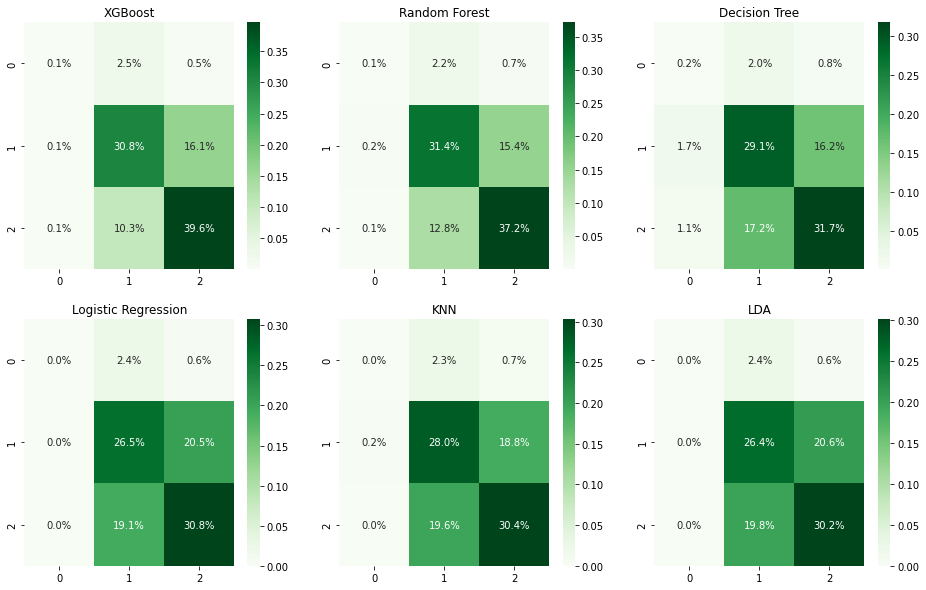

In [65]:
# Setting figure to compare the confusion matrix of each model based on heatmaps
fig, ax = plt.subplots(figsize = (16,10))
ax.set_title('Top 6 confusion matrices', size = 17, pad = 10)

# XGBoost Classifier
plt.subplot(2,3,1)
sns.heatmap(confusion_matrix(Y_test, np.round(xgbc_y_pred))/np.sum(confusion_matrix(Y_test, np.round(xgbc_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('XGBoost')

# Random Forest Classifier
plt.subplot(2,3,2)
sns.heatmap(confusion_matrix(Y_test, np.round(rfc_y_pred))/np.sum(confusion_matrix(Y_test, np.round(rfc_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('Random Forest')

# Decision Tree Classifier
plt.subplot(2,3,3)
sns.heatmap(confusion_matrix(Y_test, np.round(dtc_y_pred))/np.sum(confusion_matrix(Y_test, np.round(dtc_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('Decision Tree')

# Logistic Regression
plt.subplot(2,3,4)
sns.heatmap(confusion_matrix(Y_test, np.round(log_y_pred))/np.sum(confusion_matrix(Y_test, np.round(log_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('Logistic Regression')

# 7-Nested Neighbours
plt.subplot(2,3,5)
sns.heatmap(confusion_matrix(Y_test, np.round(knn_7_y_pred))/np.sum(confusion_matrix(Y_test, np.round(knn_7_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('KNN')

# Linear Discriminant Analysis
plt.subplot(2,3,6)
sns.heatmap(confusion_matrix(Y_test, np.round(lda_y_pred))/np.sum(confusion_matrix(Y_test, np.round(lda_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('LDA')

plt.savefig('figures/rec/Top 6 confusion matrices')

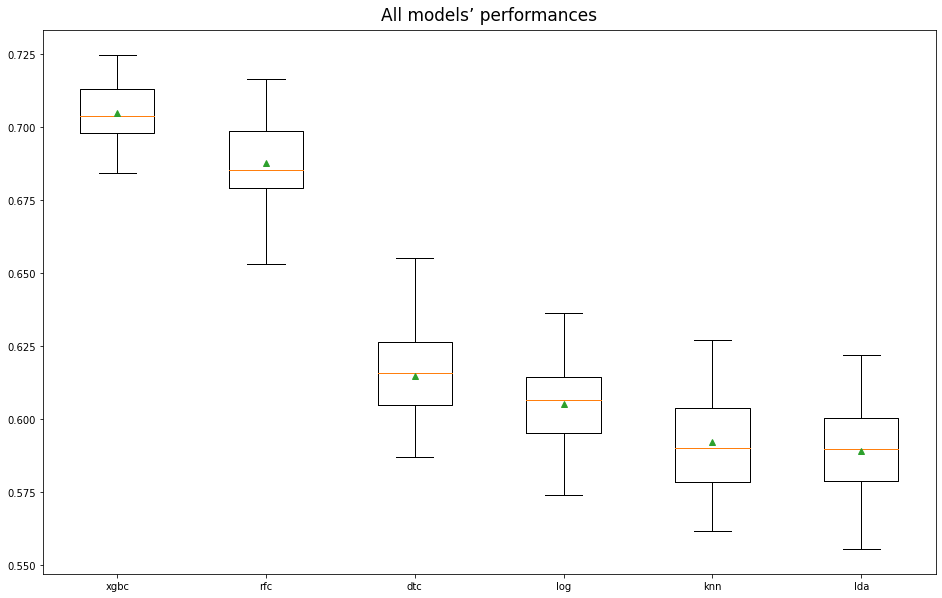

In [66]:
#URL: https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

fig, ax = plt.subplots(figsize = (16,10))

# get a list of models to evaluate
def get_models():
	models = dict()
	models['xgbc'] = xgbc
	models['rfc'] = rfc
	models['dtc'] = dtc
	models['log'] = log
	models['knn'] = knn_7
	models['lda'] = lda
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, Y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, X, Y)
  results.append(scores)
  names.append(name)

# plot model performance for comparison
ax.set_title('Top 6 models’ performances', size = 17, pad = 10)
pyplot.boxplot(results, labels=names, showmeans=True)
fig.savefig('figures/rec/Top 6 models’ performances', dpi=fig.dpi)

Orange lines indicate accuracy mean, green triangles - mean accuracy per model.

## Part 7: <a class="anchor" id="part7"></a> Fine-tuning

### 7.1  <a class="anchor" id="7_1"></a> XGBoost grid search

In [68]:
# Look at parameters used by our current XGBoost model
print('Parameters currently in use:\n')
pprint(xgbc.get_params())

Parameters currently in use:

{'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'mlogloss',
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.05,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'objective': 'multi:softprob',
 'predictor': 'auto',
 'random_state': 1,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'use_label_encoder': False,
 'validate_parameters': 1,
 'verbosity': None}


In [69]:
#URL: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

# Defining parameter range
xgbc_grid = {'learning_rate':[0.1],
    'n_estimators':[1000],
    'max_depth':[4,5,6],
    'min_child_weight':[6,8,10,12],
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'objective':['binary:logistic'],
    'nthread':[4],
    'scale_pos_weight':[1],
    'seed':[1],
    'metric':['multiclass'],
    'eval_metric':['mlogloss']}

pprint(xgbc_grid)

{'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
 'eval_metric': ['mlogloss'],
 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
 'learning_rate': [0.1],
 'max_depth': [4, 5, 6],
 'metric': ['multiclass'],
 'min_child_weight': [6, 8, 10, 12],
 'n_estimators': [1000],
 'nthread': [4],
 'objective': ['binary:logistic'],
 'scale_pos_weight': [1],
 'seed': [1],
 'subsample': [0.6, 0.7, 0.8, 0.9]}


In [72]:
# Fitting the model for grid search
xgbc_tuned = GridSearchCV(XGBClassifier(), xgbc_grid, refit = True)
xgbc_tuned.fit(X_train, Y_train.values.ravel())

[13:23:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:23:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "sca

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...
                                     reg_lambda=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'eval_metric': ['mlogloss'],
                         'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'learning_rate': [0.1], 'max_depth': [4, 5, 6],
                         'metric': ['multiclass'],
                         'min_child_weight': [6, 8, 10, 12],
                         'n_estimators': [1000], 'nthread': [4],
                         'objective': ['binary:logistic'],
                         'scale_pos_weight': [1], 'seed': [1],
                         'subsample': [0.6, 0.7, 0.8, 0.9]})

In [73]:
# Print best parameter after tuning
print(xgbc_tuned.best_params_)
 
# Print how our model looks after hyper-parameter tuning
print(xgbc_tuned.best_estimator_)

{'colsample_bytree': 0.6, 'eval_metric': 'mlogloss', 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'metric': 'multiclass', 'min_child_weight': 6, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'seed': 1, 'subsample': 0.8}
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0.3, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
              metric='multiclass', min_child_weight=6, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=4, nthread=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)


In [75]:
# Base model results
xgbc_base_y_pred = xgbc.predict(X_test)
xgbc_base_accuracy = round(metrics.accuracy_score(Y_test, np.round(xgbc_base_y_pred)), 3)*100
print('Accuracy of base XGBC is ' + str(xgbc_base_accuracy)+'%')

# Tuned model results
xgbc_tuned = xgbc_tuned.best_estimator_
xgbc_tuned.fit(X_train, Y_train.values.ravel())
xgbc_tuned_y_pred = xgbc_tuned.predict(X_test)
xgbc_tuned_accuracy = round(metrics.accuracy_score(Y_test, np.round(xgbc_tuned_y_pred)), 3)*100
print('Accuracy of tuned XGBC is ' + str(xgbc_tuned_accuracy)+'%')

# Comparison
print('Improvement of {:0.1f}%'.format(100 * (xgbc_tuned_accuracy - xgbc_base_accuracy) / xgbc_base_accuracy))

Accuracy of base XGBC is 70.5%
[12:01:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy of tuned XGBC is 69.69999999999999%
Improvement of -1.1%


### 7.2  <a class="anchor" id="7_2"></a> Random forest classifier grid search

In [76]:
# Look at parameters used by our current random forest
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [77]:
# URL: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto','sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
                     'max_features': max_features,
                     'max_depth': max_depth,
                     'min_samples_split': min_samples_split,
                      'min_samples_leaf': min_samples_leaf,
                      'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [78]:
rfc_tuned = RandomizedSearchCV(estimator = rfc,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 5,
                               verbose = 2,
                               random_state = 1,
                               n_jobs = -1)
                               
# Fit the random search model
rfc_tuned.fit(X_train, Y_train.values.ravel())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=1, verbose=2)

In [79]:
# Base model results
rfc_base_y_pred = rfc.predict(X_test)
rfc_base_accuracy = round(metrics.accuracy_score(Y_test, np.round(rfc_base_y_pred)), 3)*100
print('Accuracy of base RFC is ' + str(rfc_base_accuracy)+'%')

# Tuned model results
rfc_tuned = rfc_tuned.best_estimator_
rfc_tuned.fit(X_train, Y_train.values.ravel())
rfc_tuned_y_pred = rfc_tuned.predict(X_test)
rfc_tuned_accuracy = round(metrics.accuracy_score(Y_test, np.round(rfc_tuned_y_pred)), 3)*100
print('Accuracy of tuned RFC is ' + str(rfc_tuned_accuracy)+'%')

# Comparison
print('Improvement of {:0.1f}%'.format(100 * (rfc_tuned_accuracy - rfc_base_accuracy) / rfc_base_accuracy))

Accuracy of base RFC is 68.7%
Accuracy of tuned RFC is 69.19999999999999%
Improvement of 0.7%


## Part 8: <a class="anchor" id="part8"></a> Ensemble learning

### 8.1  <a class="anchor" id="8_1"></a> Voting classifier

In [70]:
soft_voting = VotingClassifier(
    estimators=[('xgbc_t', xgbc_tuned), ('rfc_t', rfc_tuned)],
    voting='soft')

soft_voting.fit(X_train, Y_train.values.ravel())
sv_y_pred = soft_voting.predict(X_test)
print(classification_report(Y_test, np.round(sv_y_pred)))

              precision    recall  f1-score   support

           0       0.33      0.02      0.03        58
           1       0.69      0.68      0.68       906
           2       0.71      0.76      0.74       963

    accuracy                           0.70      1927
   macro avg       0.58      0.49      0.48      1927
weighted avg       0.69      0.70      0.69      1927



In [71]:
print('Accuracy score of soft voting classifier: ' + str(round(metrics.accuracy_score(Y_test, np.round(sv_y_pred)), 3)*100)+'%')
print('Precision score of soft voting classifier: ' + str(round(metrics.precision_score(Y_test, np.round(sv_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of soft voting classifier ' + str(round(metrics.recall_score(Y_test, np.round(sv_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of soft voting classifier: ' + str(round(metrics.f1_score(Y_test, np.round(sv_y_pred), average='weighted'), 3)*100)+'%')
sv_cv = cross_val_score(soft_voting, X_train, Y_train.values.ravel(), cv=5, scoring='accuracy')
print('Final accuracy score of soft voting classifier on validation dataset is ' + str(round(sv_cv[1],3)*100) + '%')

Accuracy score of voting classifier: 70.0%
Precision score of voting classifier: 68.89999999999999%
Recall score of voting classifier 70.0%
F1 of voting classifier: 69.0%
Final accuracy score of voting classifier on validation dataset is 68.8%


In [ ]:
hard_voting = VotingClassifier(
    estimators=[('xgbc_t', xgbc_tuned), ('rfc_t', rfc_tuned)],
    voting='hard')

hard_voting.fit(X_train, Y_train.values.ravel())
hv_y_pred = hard_voting.predict(X_test)
print(classification_report(Y_test, np.round(hv_y_pred)))

In [ ]:
print('Accuracy score of hard voting classifier: ' + str(round(metrics.accuracy_score(Y_test, np.round(hv_y_pred)), 3)*100)+'%')
print('Precision score of hard voting classifier: ' + str(round(metrics.precision_score(Y_test, np.round(hv_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of hard voting classifier ' + str(round(metrics.recall_score(Y_test, np.round(hv_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of hard voting classifier: ' + str(round(metrics.f1_score(Y_test, np.round(hv_y_pred), average='weighted'), 3)*100)+'%')
hv_cv = cross_val_score(hard_voting, X_train, Y_train.values.ravel(), cv=5, scoring='accuracy')
print('Final accuracy score of hard voting classifier on validation dataset is ' + str(round(hv_cv[1],3)*100) + '%')

### 8.2  <a class="anchor" id="8_2"></a> Stacking

>log 0.497 (0.002)
>knn 0.587 (0.016)
>dtc 0.625 (0.012)
>rfc 0.697 (0.012)
>xgbc 0.714 (0.012)
>stacking 0.712 (0.013)


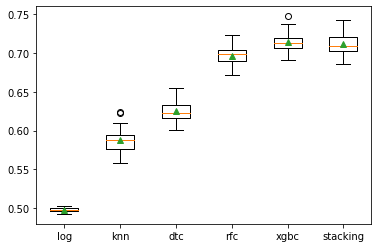

In [35]:
#URL: https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('log', log))
	level0.append(('knn', knn_7))
	level0.append(('dtc', dtc))
	level0.append(('rfc', rfc))
	level0.append(('xgbc', xgbc))

	# define meta learner model
	level1 = xgbc
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate
def get_models():
	models = dict()
	models['log'] = log
	models['knn'] = knn_7
	models['dtc'] = dtc
	models['rfc'] = rfc
	models['xgbc'] = xgbc
	models['stacking'] = get_stacking()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, Y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, Y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>voting 0.713 (0.013)
>rfc 0.697 (0.012)
>xgbc 0.714 (0.012)
>stacking 0.710 (0.014)


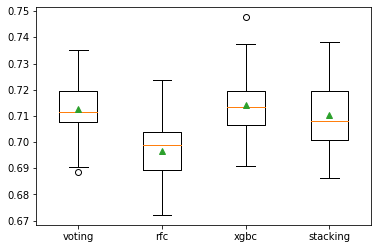

In [36]:
#URL: https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('voting', voting_clf))
	level0.append(('rfc', rfc))
	level0.append(('xgbc', xgbc))

	# define meta learner model
	level1 = xgbc
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate
def get_models():
	models = dict()
	models['voting'] = voting_clf
	models['rfc'] = rfc
	models['xgbc'] = xgbc
	models['stacking'] = get_stacking()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, Y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, Y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
fig.savefig('figures/Best models', dpi=fig.dpi)
pyplot.show()

The best fine-tuned model considered for final evaluation is defined below and is called 'final'.

In [37]:
# Define the base models
level0 = list()
level0.append(('rfc', rfc))
level0.append(('xgbc', xgbc))
level0.append(('voting', voting_clf))
level0.append(('stacking', get_stacking()))

# Define meta learner model
level1 = xgbc

# Define the final stacking ensemble
final = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

# Fit the model on all available data
final = final.fit(X, Y.values.ravel())

# Make a prediction for one example
random_project = X.sample(n=1)
yhat = final.predict(random_project)
print('Predicted Recoverability Class: %d' % (yhat))

Predicted Recoverability Class: 1


In [38]:
# Predict the response for test set
final_y_pred = final.predict(X_test)

In [39]:
# Accuracy measures
print('Accuracy score of the final model: ' + str(round(metrics.accuracy_score(Y_test, np.round(final_y_pred)), 3)*100)+'%')
print('Precision score of the final model: ' + str(round(metrics.precision_score(Y_test, np.round(final_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of the final model: ' + str(round(metrics.recall_score(Y_test, np.round(final_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of final the model: ' + str(round(metrics.f1_score(Y_test, np.round(final_y_pred), average='weighted'), 3)*100)+'%')
final_cv = cross_val_score(final, X_train, Y_train.values.ravel(), cv=6, scoring='accuracy')
print('Final accuracy score on validation dataset is ' + str(round(final_cv[1],3)*100) + '%')

Accuracy score of final model: 82.39999999999999%
Precision score of final model: 80.10000000000001%
Recall score of final model: 82.39999999999999%
F1 of final model: 81.2%
Final accuracy score on validation dataset is 69.3%


## Part 9: <a class="anchor" id="part9"></a> Evaluation of the final model

### 9.1  <a class="anchor" id="9_1"></a> Feature importance - **DOESN'T WORK FOR STACKING CLASSIFIERS**

In [40]:
# Create a new DataFrame for feature importance
#final.feature_names = X.columns
#final_feature_importance = pd.DataFrame({'Feature': final.feature_names,'Importance':final.feature_importances_})
#final_feature_importance = final_feature_importance.sort_values(by = ['Importance'], ascending = False)

In [41]:
# Plotting a bar plot for feature importance - VERSION 1
#fig, ax = plt.subplots(figsize = (16,10))
#sns.barplot(final_feature_importance['Importance'], final_feature_importance['Feature'], color = 'darkgreen')
#plt.xlabel('Importance Score')
#plt.ylabel('Features')
#plt.xticks(rotation = 'horizontal')
#plt.title('Feature Importance')
#plt.savefig('Feature Importance.png')

In [42]:
# Plotting a bar plot for feature importance - VERSION 1
%matplotlib inline

#plt.figure(figsize = (14,7))
#sns.barplot(final_feature_importance['Feature'], final_feature_importance['Importance'], color = 'darkgreen')
#plt.title('Feature Importance')
#plt.xlabel('Features')
#plt.ylabel('Feature Importance Score')
#plt.xticks(rotation = 'vertical')
#plt.legend()
#plt.show()

In [43]:
# Generating the model on all features

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1, stratify=Y)

#final.fit(X_train,Y_train.values.ravel())
#y_pred = final.predict(X_test)
#print('Accuracy of the final model with all features is ' + str(round(metrics.accuracy_score(Y_test, np.round(y_pred)), 3)*100)+'%')

In [44]:
# 1 feature dropped

#X = X[[...]]
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1, stratify=Y)

#final.fit(X_train,Y_train.values.ravel())
#y_pred = final.predict(X_test)
#print('Accuracy of the final model with 1 feature dropped is ' + str(round(metrics.accuracy_score(Y_test, np.round(y_pred)), 3)*100)+'%')

Diminishing returns in performance occur after dropping just X feature(s), therefore all of the original features were kept to maintain maximum accuracy.

### 9.2  <a class="anchor" id="9_2"></a> Confusion matrix

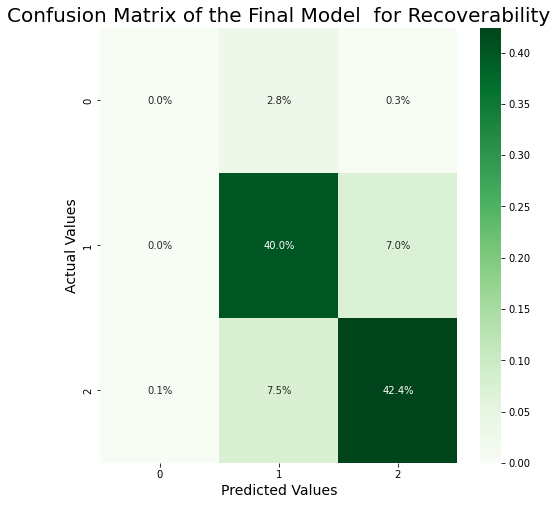

In [45]:
# Final model confusion matrix heatmap
plt.subplots(figsize = (8,8))
sns.heatmap(confusion_matrix(Y_test, np.round(final_y_pred))/np.sum(confusion_matrix(Y_test, np.round(final_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.xlabel('Predicted Values', fontsize = 14) 
plt.ylabel('Actual Values', fontsize = 14)
plt.title('Confusion Matrix of the Final Model  for Recoverability', fontsize = 20)
plt.savefig('figures/Confusion Matrix of the Final Model for Recoverability.png')

### 9.3  <a class="anchor" id="9_3"></a> ROC curve

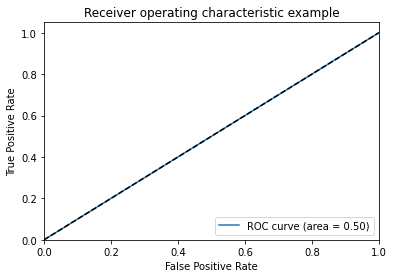

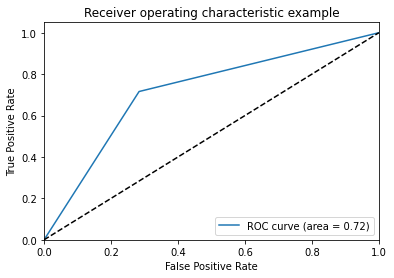

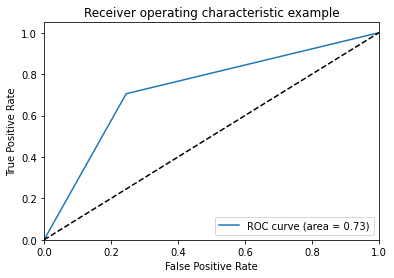

In [46]:
#URL: https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification

#  Refresh data that is ultimately used after dropping least important features
#X = df[[...]]
#Y = df['...']

# Shuffle and split training and test sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Binarize the output
Y = label_binarize(Y, classes=[0, 1, 2])
n_classes = Y.shape[1]

# Learn to predict each class against the other
#RFC = RandomForestClassifier(100, random_state = 1)
XGBC = XGBClassifier(n_estimators=100, learning_rate=0.05, booster='gbtree', random_state = 1)
OVRC = OneVsRestClassifier(XGBC)
OVRC.fit(X_train, Y_train)

Y = label_binarize(Y, classes=[0,1,2])
n_classes = 3

# shuffle and split training and test sets
X_train, X_test, Y_train, Y_test =\
    train_test_split(X, Y, test_size=0.2, random_state=1)

# classifier
y_score = OVRC.fit(X_train, Y_train).predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc='lower right')
    plt.show()

### 9.4  <a class="anchor" id="9_4"></a> Precision-recall curve - **CODE IS FOR BINARY CLASSIFICATION!**

In [ ]:
# Predict class values
yhat = final.predict(X_test)
final_precision, final_recall, _ = precision_recall_curve(Y_test, np.round(final_probs))
final_f1, final_auc = f1_score(Y_test, yhat), auc(final_recall, final_precision)

# Summarize scores
print('Final model scores: f1=%.1f auc=%.1f' % (final_f1, final_auc))

# Plot the precision-recall curves
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No skill', color='orange')
pyplot.plot(final_recall, final_precision, marker='.', label='Final model', color='green')

pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
ax.set_title("Precision-recall curve", size = 17, pad = 10)
fig.savefig("Precision-recall curve.png", dpi=fig.dpi)

## Part 10: <a class="anchor" id="part10"></a> Pipeline creation